
# HW10 Assignment I - Spatial Data Analysis
This notebook was started in class as Lab 9 presented by Sina Kashuk. 

## Import initial libraries

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import json
import requests
import urllib2
import statsmodels.api as sm
import shapely
import seaborn as sns

import pysal as ps


import matplotlib.pylab as pl
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File

In [8]:
from geopandas import GeoDataFrame
shape_path="ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [9]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Census Tract boundaries colored by boroughs

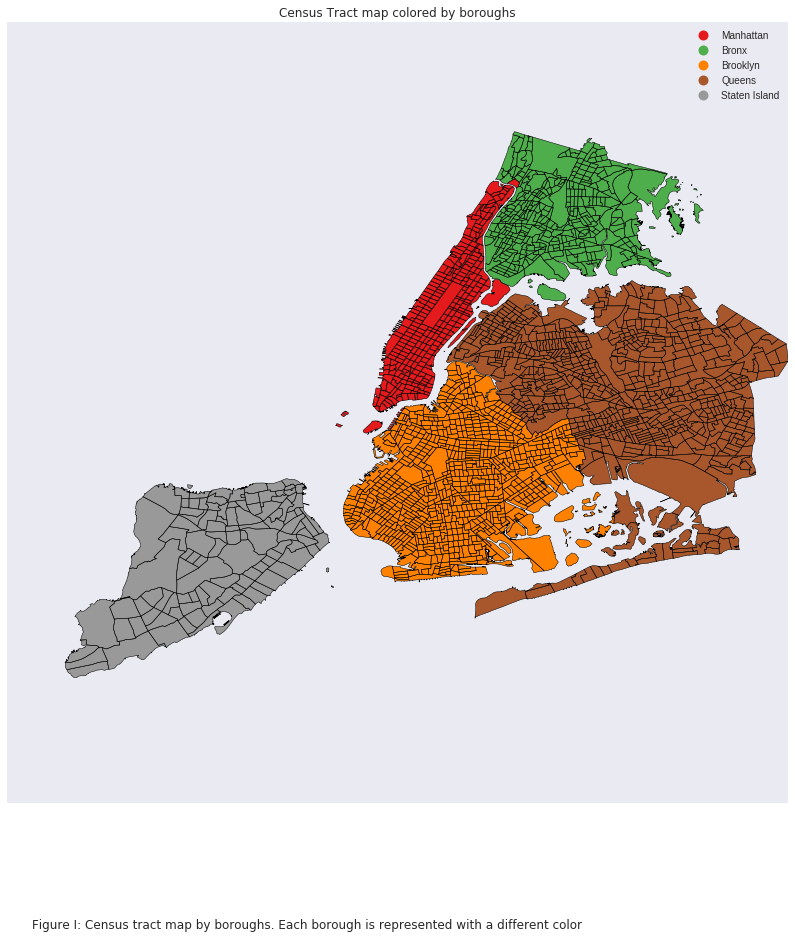

In [11]:
f, ax = pl.subplots(figsize=(14,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax, legend=True, )
legend = ax.get_legend()
legend.get_texts()[0].set_text('Manhattan')
legend.get_texts()[1].set_text('Bronx')
legend.get_texts()[2].set_text('Brooklyn')
legend.get_texts()[3].set_text('Queens')
legend.get_texts()[4].set_text('Staten Island')

pl.title("Census Tract map colored by boroughs")
pl.figtext(0.15,0,"Figure I: Census tract map by boroughs. Each borough is represented with a different color. ")

### Map NYC Population density

#### Load Census Data for 2010

In [12]:
ct_data=DataFrame.from_csv('ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [13]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

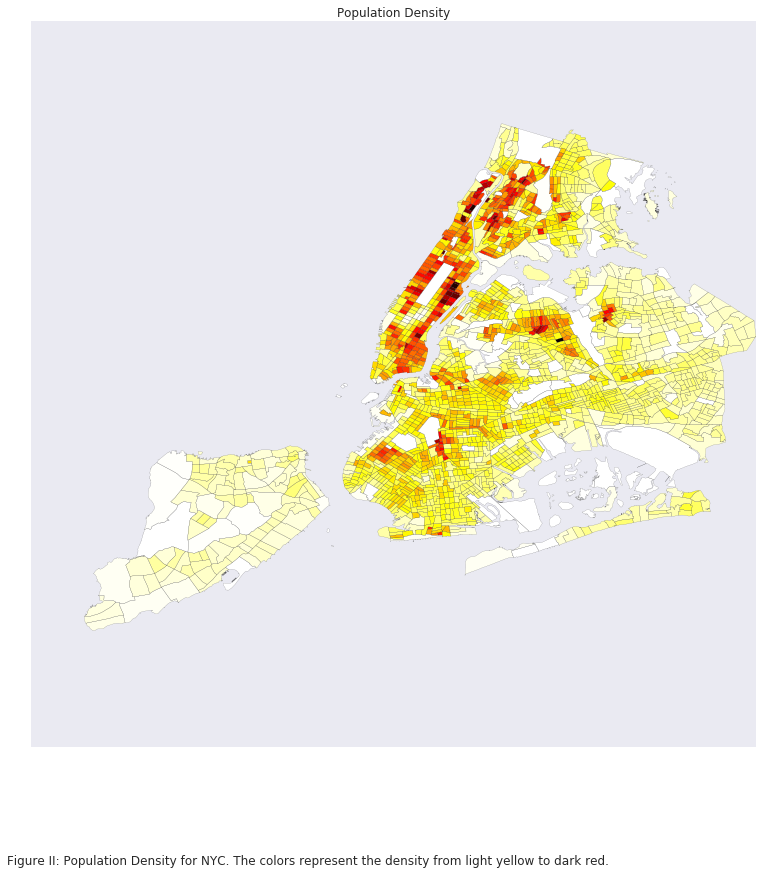

In [15]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")
pl.figtext(0.1,0,"Figure II: Population Density for NYC. The colors represent the density from light yellow to dark red.")

## Explore CitiBike data

### Load CitiBike data

In [16]:
df_bike_monthly=DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


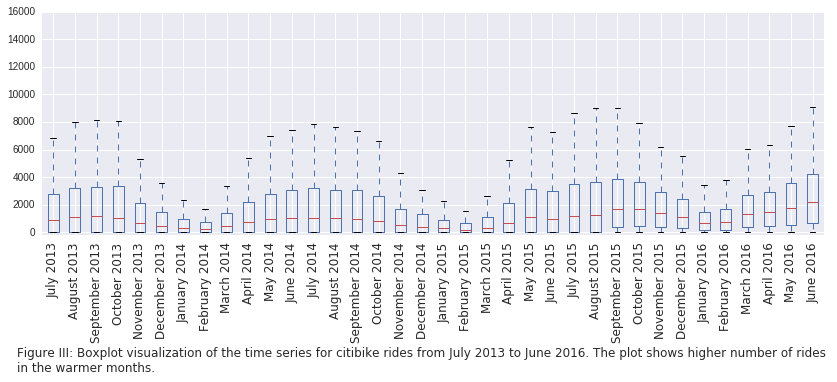

In [21]:
# Create a boxplot to visualize

pl.rcParams['font.size']=12
f, ax = pl.subplots(figsize=(14,4))

df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

pl.figtext(0.1,-.35,"Figure III: Boxplot visualization of the time series for citibike rides " 
          "from July 2013 to June 2016. The plot shows higher number of rides \n" 
           "in the warmer months.")

#### Seasonal Decomposition

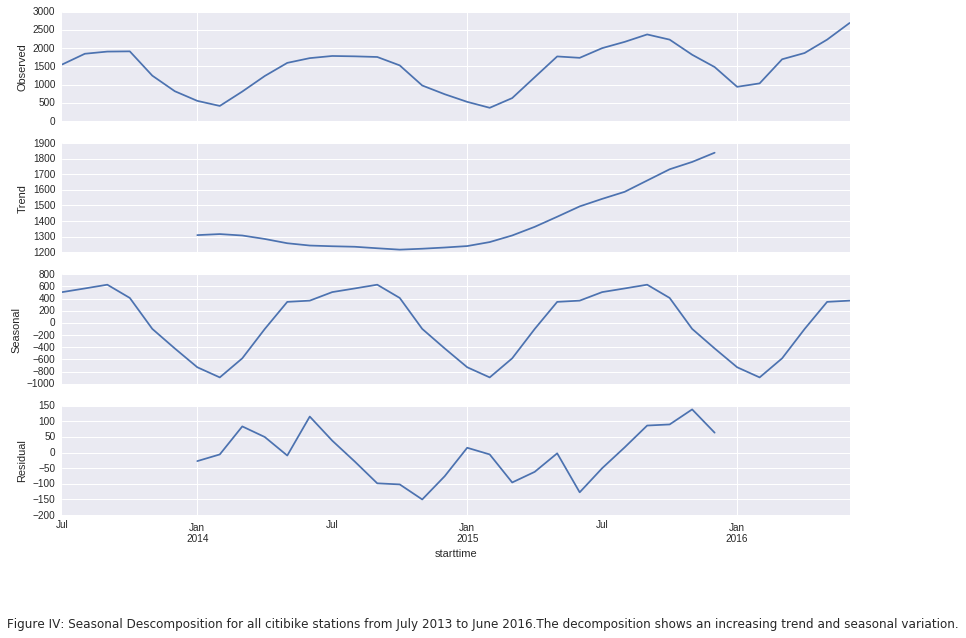

In [22]:
# Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

# Seasonal Decomposition using statsmodels api
# http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
pl.figtext(0.01,-.1,"Figure IV: Seasonal Descomposition for all citibike stations from July 2013 to June 2016."
           "The decomposition shows an increasing trend and seasonal variation.")

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [23]:
station_id=DataFrame.from_csv('Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [24]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [25]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [26]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [27]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [28]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [29]:
# use a temporary df to join
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


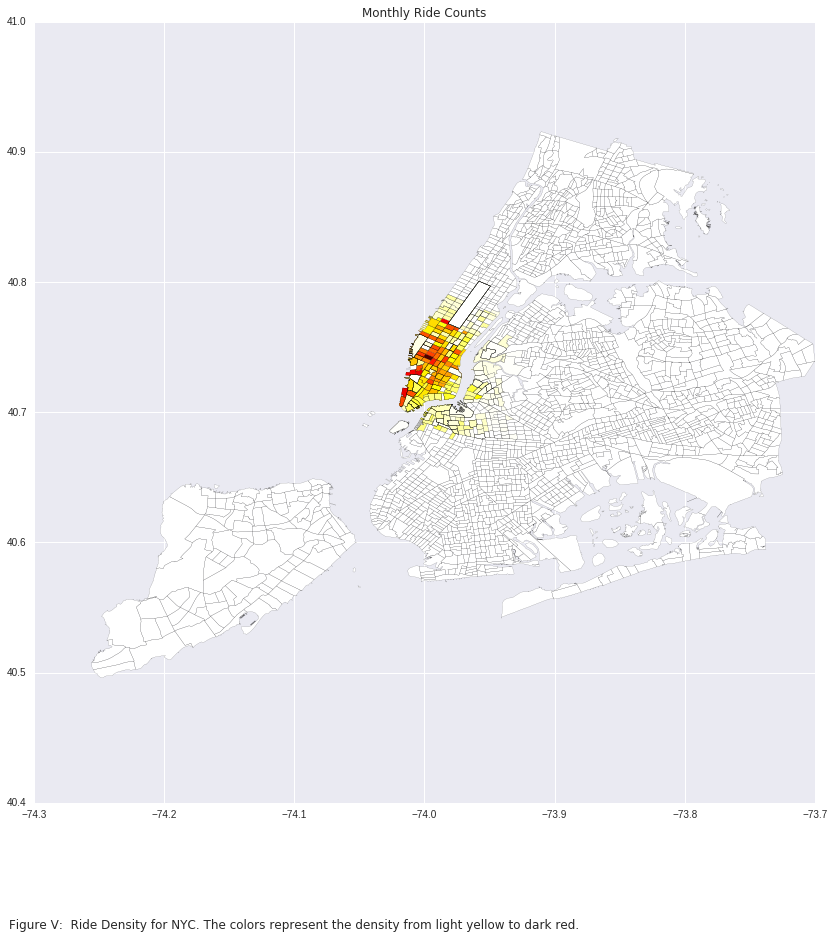

In [30]:
f, ax = pl.subplots(figsize=(14,14))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Monthly Ride Counts")
pl.figtext(0.1,0,"Figure V:  Ride Density for NYC. The colors represent the density from light yellow to dark red.")

### Removing the CTs that are out of zoom boundries

In [31]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [32]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

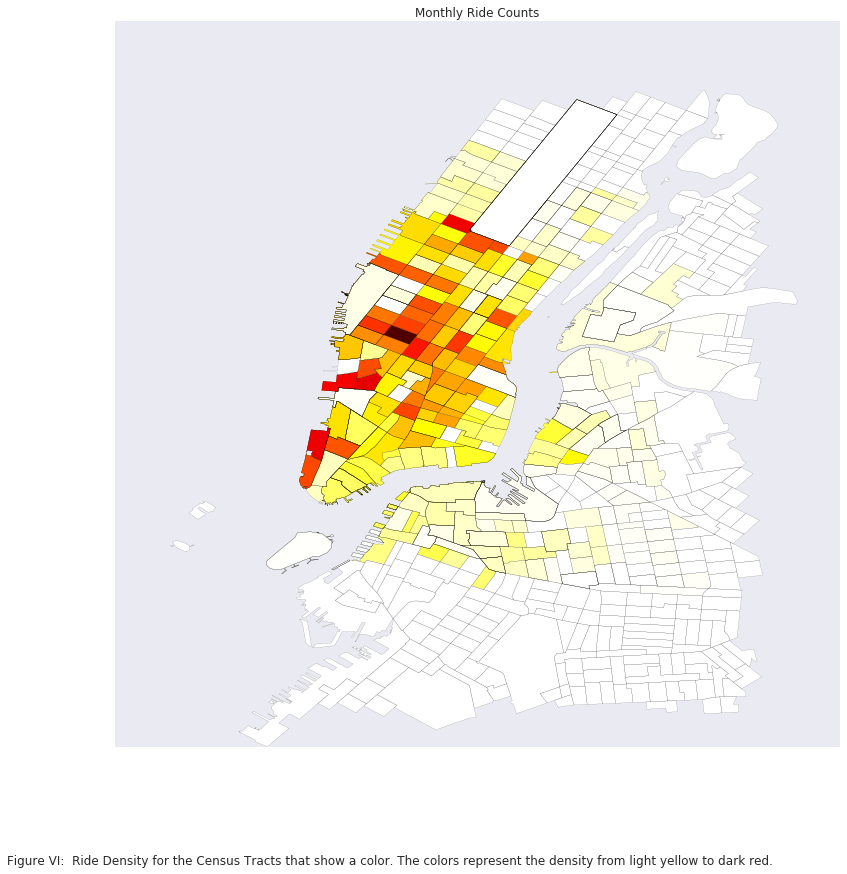

In [34]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Monthly Ride Counts")

pl.figtext(0.01,0,"Figure VI:  Ride Density for the Census Tracts that show a color. The colors represent the density "
           "from light yellow to dark red. ")

### Export Shapefile CTs in the CitiBike Zone

In [35]:
path='ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [37]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [38]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [39]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [40]:
Wmatrix, ids = qW_CT.full()

In [41]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [42]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [43]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [44]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80


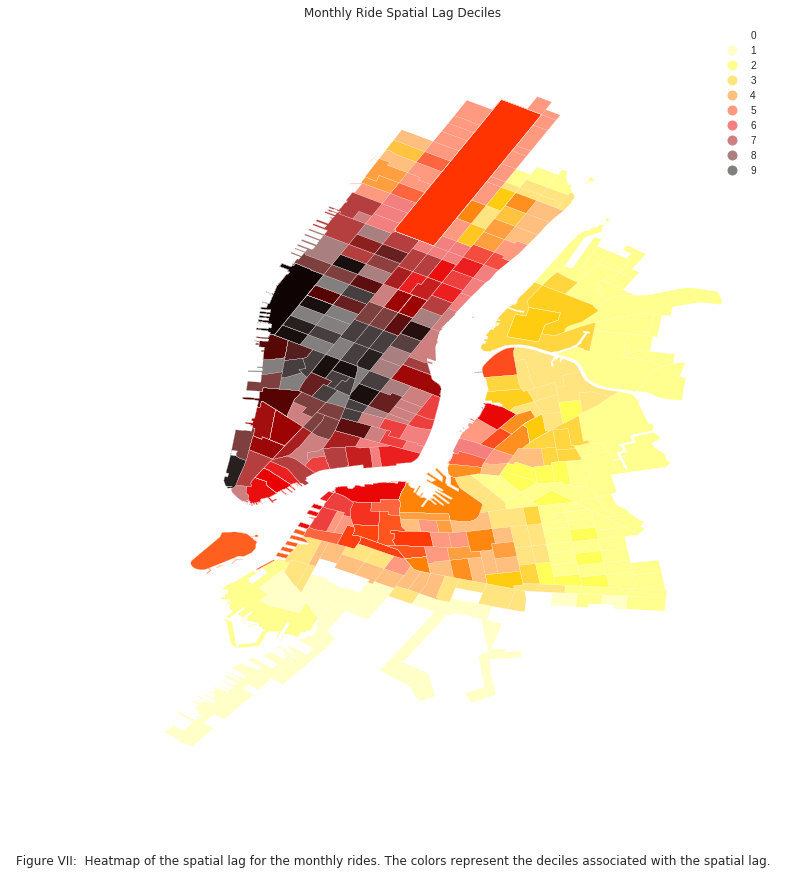

In [46]:
# Create a color map using the deciles
f, ax = pl.subplots(figsize=(13, 13))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
pl.title("Monthly Ride Spatial Lag Deciles")
pl.figtext(0.1,0,"Figure VII:  Heatmap of the spatial lag for the monthly rides. "
           "The colors represent the deciles associated with the spatial lag. ")

print (MonthlyRideLagQ10)

## Global  Spatial Autocorrelation

In [47]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

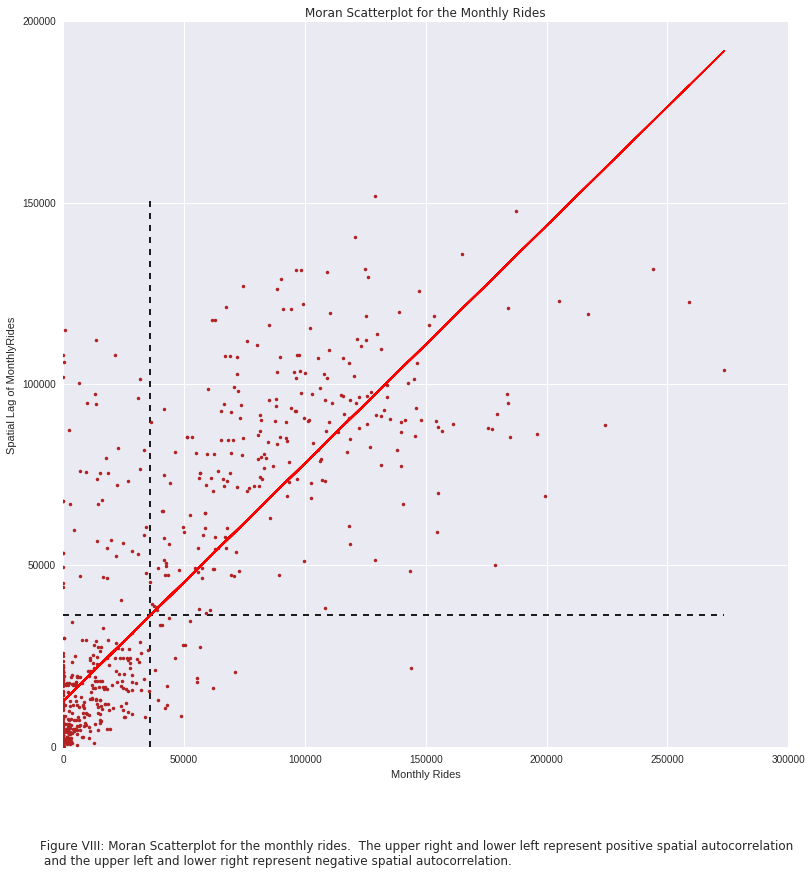

In [52]:
f, ax = pl.subplots(1, figsize=(13 , 13))

pl.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(MonthlyRide, a + b*MonthlyRide, 'r')
pl.title('Moran Scatterplot for the Monthly Rides')
pl.ylabel('Spatial Lag of MonthlyRides')
pl.xlabel('Monthly Rides')

pl.figtext(0.1,0,"Figure VIII: Moran Scatterplot for the monthly rides. "
           " The upper right and lower left represent positive spatial autocorrelation \n and the"
           " upper left and lower right represent negative spatial autocorrelation. ")

### Moran's I

In [53]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [54]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [55]:
I_MonthlyRide.sim[0:10]

array([ 0.00926874, -0.00046116, -0.00799023,  0.00202282,  0.00264595,
       -0.01007257, -0.00129177, -0.03661258,  0.00020711,  0.01218613])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [56]:
pl.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

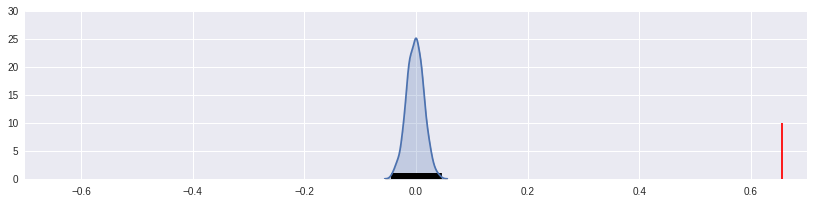

In [57]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
pl.vlines(I_MonthlyRide.sim, 0, 1)
pl.vlines(I_MonthlyRide.I, 0, 10, 'r')
pl.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

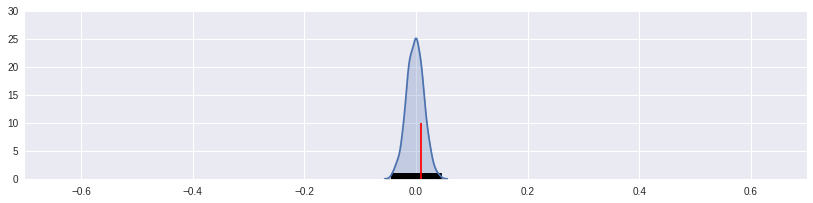

In [58]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
pl.vlines(I_MonthlyRide.sim, 0, 1)
pl.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
pl.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [59]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [60]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.188,  0.398,  0.417,  0.456]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [61]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

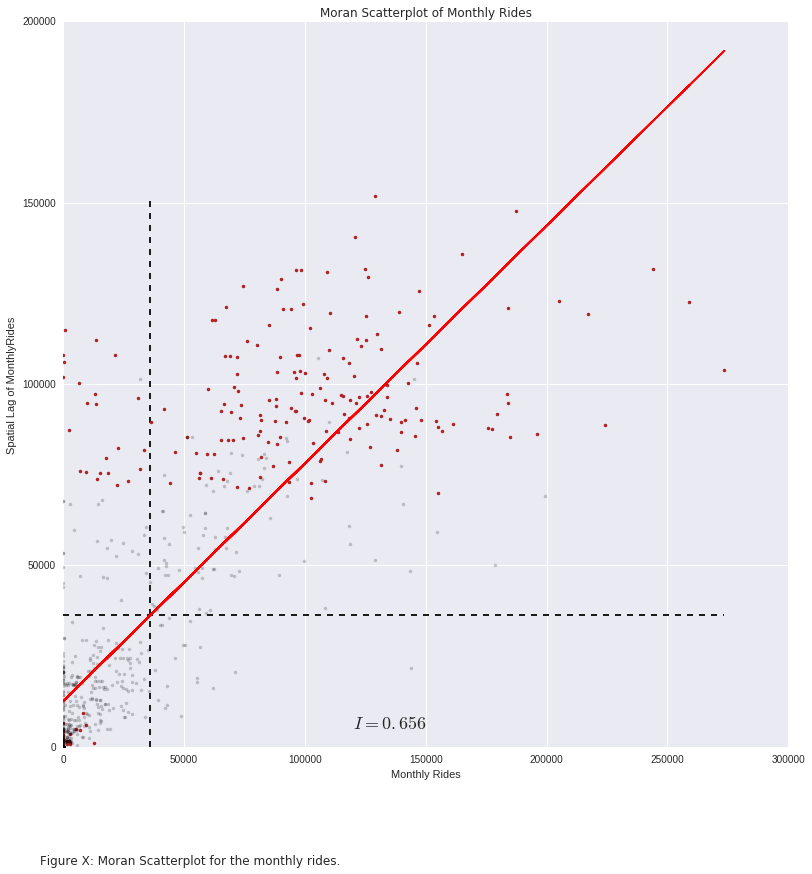

In [62]:
f, ax = pl.subplots(figsize=(13, 13))
pl.plot(sigs, W_sigs, '.', color='firebrick')
pl.plot(insigs, W_insigs, '.k', alpha=.2)
pl.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

# dashed vert at mean of the monthly ride
pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of the Monthly Ride Lag
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(MonthlyRide, a + b*MonthlyRide, 'r')
pl.title('Moran Scatterplot of Monthly Rides')
pl.ylabel('Spatial Lag of MonthlyRides')
pl.xlabel('Monthly Rides')

pl.figtext(0.1,0,"Figure X: Moran Scatterplot for the monthly rides. ")

### Hot and Cold spots 

In [63]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 191
Number of Coldspots: 239


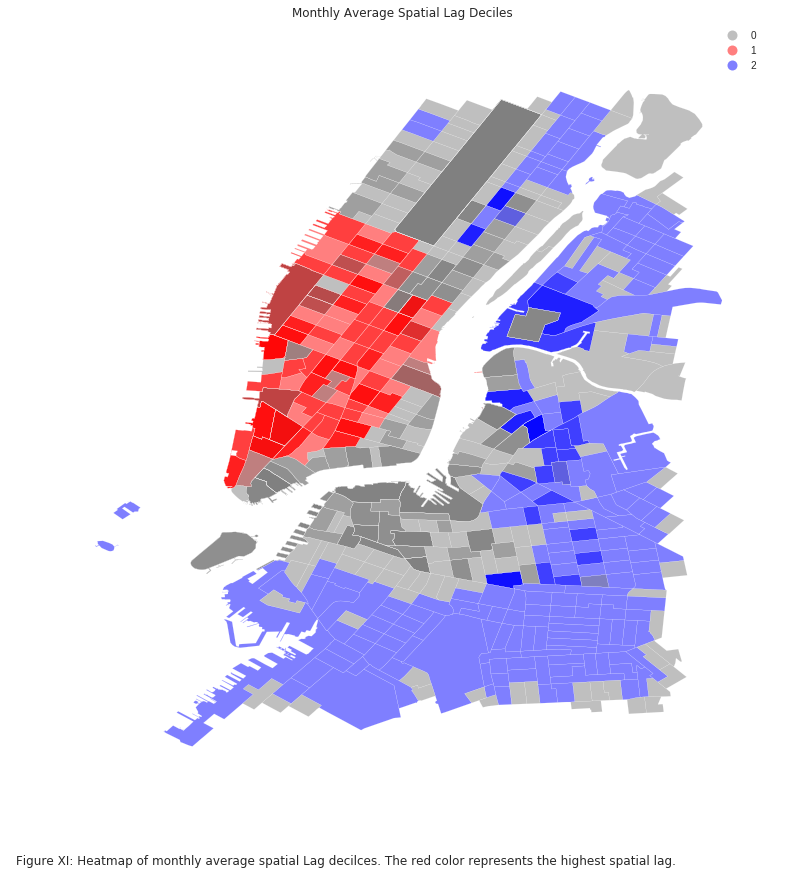

In [64]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = pl.subplots(figsize=(13, 13))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
pl.title("Monthly Average Spatial Lag Deciles")

pl.figtext(0.1,0,"Figure XI: Heatmap of monthly average spatial Lag decilces."
          " The red color represents the highest spatial lag.")